# test_lensed_quasar_time_delay_8sample

8-lens quasar time-delay forecast from `data/test_data.py`.

Key logic:
- Use only the longest time-delay pair (`max |dt|`) for each target.
- TDCOSMO fiducial cosmology: `H0=70`, `Omegam=0.3`.
- Set MST population truth to `lambda_mean=1.0`, `lambda_sigma=0.1` and draw per-lens `lambda_true`.
- External convergence is per-lens only (no population-level inference):
  - `kext_true ~ N(0, 0.01)`
  - `kext_obs = clean/noisy`
  - `kext_err = 0.01`
- Use `lambda_eff = (1-k_ext)*lambda` in both mock generation and inference likelihood.
- Use kinematic errors to define per-lens MST measurement uncertainty via `frac(lambda_err)=2*frac(sigma_v_err/sigma_v)`.
- Treat provided time delays as unbiased base values and build `t_measured_true = lambda_eff_true * t_base`.
- Each scenario runs with both `clean` and `noisy` observations.
- Three scenarios:
  1) `fiducial_no_extra`: infer lambda population and use MST measurements with no extra 8% MST error.
  2) `fiducial_plus8`: infer lambda population and add 8% (`TDCOSMO_increase_error=0.08`) to individual MST measurement error.
  3) `population_only_no_mst_measure`: no MST measurement term and fixed known lambda population (`lambda_mean`, `lambda_sigma`).
- Inference always samples `Omegam` and `H0`; first two scenarios also sample `lambda_mean` and `lambda_sigma`.



In [1]:
import os
import sys
from pathlib import Path
import importlib.util

import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, init_to_value
from jax import random
import arviz as az
from corner import corner

os.environ.setdefault('HDF5_USE_FILE_LOCKING', 'FALSE')

cwd = Path.cwd().resolve()
repo_root = None

if (cwd / 'slcosmo').is_dir() and (cwd / 'data').is_dir():
    repo_root = cwd
elif (cwd / 'LensedUniverse' / 'slcosmo').is_dir():
    repo_root = cwd / 'LensedUniverse'
else:
    for candidate in [cwd, *cwd.parents]:
        if (candidate / 'slcosmo').is_dir() and (candidate / 'data').is_dir():
            repo_root = candidate
            break

if repo_root is None:
    raise RuntimeError(f'Cannot locate LensedUniverse repo root from cwd={cwd}')

workdir = repo_root
os.chdir(workdir)
if str(workdir) not in sys.path:
    sys.path.insert(0, str(workdir))

from slcosmo.tools import tool

USE_X64 = os.environ.get('SLCOSMO_USE_X64', '0').strip().lower() in {'1', 'true', 'yes', 'y', 'on'}
jax.config.update('jax_enable_x64', USE_X64)
if USE_X64:
    numpyro.enable_x64()
if any(d.platform == 'gpu' for d in jax.devices()):
    numpyro.set_platform('gpu')
else:
    numpyro.set_platform('cpu')

print('Precision mode:', 'FP64' if USE_X64 else 'FP32')
print('Repo root:', workdir)
print('JAX devices:', jax.devices())

SEED = 42
rng_np = np.random.default_rng(SEED)
np.random.seed(SEED)

RESULT_DIR = workdir / 'test'
RESULT_DIR.mkdir(parents=True, exist_ok=True)


/home/skylee/anaconda3/lib/python3.12/site-packages/pandas/core/computation/expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.8.7' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/skylee/anaconda3/lib/python3.12/site-packages/pandas/core/arrays/masked.py:56: UserWarning: Pandas requires version '1.4.2' or newer of 'bottleneck' (version '1.3.7' currently installed).
  from pandas.core import (


Precision mode: FP32
Repo root: /mnt/d/lensing/LensedUniverse
JAX devices: [CpuDevice(id=0)]


In [2]:
# ---------------------------
# Load 8-lens dataset and keep only the longest delay pair per target
# ---------------------------
data_path = workdir / 'data' / 'test_data.py'
spec = importlib.util.spec_from_file_location('test_data', data_path)
test_data = importlib.util.module_from_spec(spec)
spec.loader.exec_module(test_data)
tdcosmo_8lens = test_data.tdcosmo_8lens

lens_names = sorted(tdcosmo_8lens.keys())

z_lens = []
z_src = []
sigma_v = []
sigma_v_err = []

pair_name = []
t_base = []
t_err = []

for name in lens_names:
    d = tdcosmo_8lens[name]
    z_lens.append(float(d['zl']))
    z_src.append(float(d['zs']))
    sigma_v.append(float(d['sigma_ap_los_kms']))
    sigma_v_err.append(float(d['sigma_ap_los_err_kms']))

    td_dict = d['time_delays_days']
    p_long = max(td_dict, key=lambda p: abs(float(td_dict[p]['dt'])))
    pair_name.append(f'{name}:{p_long}')
    dt_val = float(td_dict[p_long]['dt'])
    de = 0.5 * (float(td_dict[p_long].get('err_minus', 0.0)) + float(td_dict[p_long].get('err_plus', 0.0)))
    t_base.append(abs(dt_val))
    t_err.append(de)

z_lens = np.asarray(z_lens, dtype=float)
z_src = np.asarray(z_src, dtype=float)
sigma_v = np.asarray(sigma_v, dtype=float)
sigma_v_err = np.asarray(sigma_v_err, dtype=float)

t_base = np.asarray(t_base, dtype=float)
t_err = np.asarray(t_err, dtype=float)

n_lens = z_lens.size
n_obs = t_base.size

print('N lens:', n_lens)
print('N time-delay observations (longest pair only):', n_obs)
for i, name in enumerate(lens_names):
    print(f'  {i:02d} {name:15s} pair={pair_name[i]} sigma_v={sigma_v[i]:.1f}+-{sigma_v_err[i]:.1f}')



N lens: 8
N time-delay observations (longest pair only): 8
  00 B1608+656       pair=B1608+656:BD sigma_v=305.3+-11.0
  01 DESJ0408-5354   pair=DESJ0408-5354:AD sigma_v=242.3+-12.2
  02 HE0435-1223     pair=HE0435-1223:AD sigma_v=226.6+-5.8
  03 PG1115+080      pair=PG1115+080:BC sigma_v=235.7+-6.6
  04 RXJ1131-1231    pair=RXJ1131-1231:CD sigma_v=303.0+-8.3
  05 SDSSJ1206+4332  pair=SDSSJ1206+4332:AB sigma_v=290.5+-9.5
  06 WFI2033-4723    pair=WFI2033-4723:BC sigma_v=210.7+-10.5
  07 WGD2038-4008    pair=WGD2038-4008:AD sigma_v=254.7+-16.3


In [3]:
# ---------------------------
# Build mock truth and observations
# ---------------------------
cosmo_true = {'Omegam': 0.3, 'Omegak': 0.0, 'w0': -1.0, 'wa': 0.0, 'h0': 70.0}

Dl, Ds, Dls = tool.dldsdls(jnp.asarray(z_lens), jnp.asarray(z_src), cosmo_true, n=20)
Ddt_lens = np.asarray((1.0 + z_lens) * Dl * Ds / Dls)
Ddt_obs = Ddt_lens

c_km_day = tool.c_km_s * 86400.0
Mpc_km = tool.Mpc / 1000.0

# Fixed MST population truth used to generate mock data
lambda_mean_true = 1.0
lambda_sigma_true = 0.1
lambda_low_model = 0.6
lambda_high_model = 1.6
lambda_true_raw = tool.truncated_normal(
    lambda_mean_true,
    lambda_sigma_true,
    lambda_low_model,
    lambda_high_model,
    n_lens,
    random_state=rng_np,
)

# Recenter finite-sample draw so the mock ensemble mean stays close to 1.0
lambda_true = lambda_true_raw - np.mean(lambda_true_raw) + 1.0
lambda_true = np.clip(lambda_true, lambda_low_model + 1e-3, lambda_high_model - 1e-3)
lambda_true = lambda_true - np.mean(lambda_true) + 1.0
lambda_true = np.clip(lambda_true, lambda_low_model + 1e-3, lambda_high_model - 1e-3)
assert np.abs(np.mean(lambda_true) - 1.0) < 0.01

# Per-lens external convergence truth and measurement error
# No population-level inference parameters for k_ext
kext_sigma = 0.01
kext_true = rng_np.normal(0.0, kext_sigma, n_lens)
kext_err = np.full(n_lens, 0.01)
kext_obs_clean = kext_true.copy()
kext_obs_noisy = rng_np.normal(kext_true, kext_err)

lambda_eff_true = (1.0 - kext_true) * lambda_true

# Individual MST measurement error from kinematics
ADDITIONAL_MST_BUDGET = 0.04
lambda_err_frac_base = 2.0 * (sigma_v_err / sigma_v) + ADDITIONAL_MST_BUDGET
TDCOSMO_increase_error = 0.08
lambda_err_frac_plus8 = lambda_err_frac_base + TDCOSMO_increase_error

lambda_err_no_extra = lambda_err_frac_base * np.abs(lambda_true)
lambda_err_plus8 = lambda_err_frac_plus8 * np.abs(lambda_true)

# Time-delay measured true value: unbiased base delays transformed by lambda_eff truth
t_measured_true = t_base * lambda_eff_true

# Infer FPD true from t = (Ddt/c) * phi * lambda_eff
phi_true = (c_km_day * t_measured_true) / (Ddt_obs * Mpc_km * lambda_eff_true)
phi_err = 0.05 * np.abs(phi_true)

# Clean and noisy observation sets
# clean: observed values equal true values
# noisy: observed values sampled from measurement uncertainty
t_obs_clean = t_measured_true.copy()
phi_obs_clean = phi_true.copy()

t_obs_noisy = rng_np.normal(t_measured_true, t_err)
phi_obs_noisy = rng_np.normal(phi_true, phi_err)

# Scale phi for numerical stability
phi_scale = 10.0 ** int(np.round(-np.log10(np.median(np.abs(phi_true)))))
phi_obs_scaled_clean = phi_obs_clean * phi_scale
phi_obs_scaled_noisy = phi_obs_noisy * phi_scale
phi_err_scaled = 0.05 * np.abs(phi_true * phi_scale)

# Three scenarios
# - First two: infer lambda population (lambda_mean, lambda_sigma)
# - Third: lambda population is fixed and known
scenario_data = {
    'fiducial_no_extra': {
        'infer_lambda_population': True,
        'use_mst_measurement': True,
        'lambda_obs_clean': lambda_true.copy(),
        'lambda_obs_noisy': rng_np.normal(lambda_true, lambda_err_no_extra),
        'lambda_err': lambda_err_no_extra.copy(),
        'kext_obs_clean': kext_obs_clean.copy(),
        'kext_obs_noisy': kext_obs_noisy.copy(),
        'kext_err': kext_err.copy(),
    },
    'fiducial_plus8': {
        'infer_lambda_population': True,
        'use_mst_measurement': True,
        'lambda_obs_clean': lambda_true.copy(),
        'lambda_obs_noisy': rng_np.normal(lambda_true, lambda_err_plus8),
        'lambda_err': lambda_err_plus8.copy(),
        'kext_obs_clean': kext_obs_clean.copy(),
        'kext_obs_noisy': kext_obs_noisy.copy(),
        'kext_err': kext_err.copy(),
    },
    'population_only_no_mst_measure': {
        'infer_lambda_population': False,
        'use_mst_measurement': False,
        'lambda_obs_clean': np.zeros_like(lambda_true),
        'lambda_obs_noisy': np.zeros_like(lambda_true),
        'lambda_err': np.ones_like(lambda_true),
        'kext_obs_clean': kext_obs_clean.copy(),
        'kext_obs_noisy': kext_obs_noisy.copy(),
        'kext_err': kext_err.copy(),
    },
}

data_modes = {
    'clean': {
        't_obs': t_obs_clean,
        'phi_obs_scaled': phi_obs_scaled_clean,
    },
    'noisy': {
        't_obs': t_obs_noisy,
        'phi_obs_scaled': phi_obs_scaled_noisy,
    },
}

print('phi_scale:', phi_scale)
print('lambda_mean_true:', lambda_mean_true)
print('lambda_sigma_true:', lambda_sigma_true)
print('lambda_true_raw_mean:', float(np.mean(lambda_true_raw)))
print('lambda_true_centered_mean:', float(np.mean(lambda_true)))
print('kext_sigma (true distribution):', kext_sigma)
print('kext_err (measurement):', np.unique(kext_err))
print('kext_true (%):', np.round(100.0 * kext_true, 3))
print('ADDITIONAL_MST_BUDGET (%):', 100.0 * ADDITIONAL_MST_BUDGET)
print('TDCOSMO_increase_error (%):', 100.0 * TDCOSMO_increase_error)
print('lambda_err_frac_base (%):', np.round(100.0 * lambda_err_frac_base, 2))
print('lambda_err_frac_plus8 (%):', np.round(100.0 * lambda_err_frac_plus8, 2))
print('scenario settings:', {k: (v['infer_lambda_population'], v['use_mst_measurement']) for k, v in scenario_data.items()})
print('data modes:', list(data_modes.keys()))





phi_scale: 100000000000.0
lambda_mean_true: 1.0
lambda_sigma_true: 0.1
lambda_true_raw_mean: 1.0543429602787524
lambda_true_centered_mean: 1.0
kext_sigma (true distribution): 0.01
kext_err (measurement): [0.01]
kext_true (%): [-0.017 -0.853  0.879  0.778  0.066  1.127  0.468 -0.859]
ADDITIONAL_MST_BUDGET (%): 4.0
TDCOSMO_increase_error (%): 8.0
lambda_err_frac_base (%): [11.21 14.07  9.12  9.6   9.48 10.54 13.97 16.8 ]
lambda_err_frac_plus8 (%): [19.21 22.07 17.12 17.6  17.48 18.54 21.97 24.8 ]
scenario settings: {'fiducial_no_extra': (True, True), 'fiducial_plus8': (True, True), 'population_only_no_mst_measure': (False, False)}
data modes: ['clean', 'noisy']


In [4]:
# ---------------------------
# LambdaCDM model: sample Omegam/H0 and optionally infer lambda population
# ---------------------------
def quasar_td_lcdm_model(
    z_lens,
    z_src,
    t_obs,
    t_err,
    phi_obs_scaled,
    phi_err_scaled,
    phi_scale,
    lambda_obs,
    lambda_err,
    kext_obs,
    kext_err,
    use_mst_measurement,
    infer_lambda_population,
):
    Omegam = numpyro.sample('Omegam', dist.Uniform(0.1, 0.5))
    h0 = numpyro.sample('h0', dist.Uniform(0.0, 150.0))

    cosmo = {'Omegam': Omegam, 'Omegak': 0.0, 'w0': -1.0, 'wa': 0.0, 'h0': h0}

    z_lens = jnp.asarray(z_lens)
    z_src = jnp.asarray(z_src)
    t_obs = jnp.asarray(t_obs)
    t_err = jnp.asarray(t_err)
    phi_obs_scaled = jnp.asarray(phi_obs_scaled)
    phi_err_scaled = jnp.asarray(phi_err_scaled)
    phi_scale = jnp.asarray(phi_scale)
    lambda_obs = jnp.asarray(lambda_obs)
    lambda_err = jnp.asarray(lambda_err)
    kext_obs = jnp.asarray(kext_obs)
    kext_err = jnp.asarray(kext_err)

    if infer_lambda_population:
        lambda_mean = numpyro.sample(
            'lambda_mean',
            dist.Uniform(0.5, 1.5),
        )
        lambda_sigma = numpyro.sample(
            'lambda_sigma',
            dist.LogUniform(0.001, 0.5),
        )
    else:
        lambda_mean = jnp.asarray(lambda_mean_true)
        lambda_sigma = jnp.asarray(lambda_sigma_true)

    with numpyro.plate('lens', z_lens.shape[0]):
        lambda_lens = numpyro.sample(
            'lambda_true',
            dist.TruncatedNormal(lambda_mean, lambda_sigma, low=lambda_low_model, high=lambda_high_model),
        )
        kext_lens = numpyro.sample('kext', dist.Normal(0.0, kext_sigma))
        if use_mst_measurement:
            numpyro.sample('lambda_like', dist.Normal(lambda_lens, lambda_err), obs=lambda_obs)
        numpyro.sample('kext_like', dist.Normal(kext_lens, kext_err), obs=kext_obs)

    lambda_eff = (1.0 - kext_lens) * lambda_lens

    Dl, Ds, Dls = tool.dldsdls(z_lens, z_src, cosmo, n=20)
    Ddt_lens = (1.0 + z_lens) * Dl * Ds / Dls
    Ddt_obs = Ddt_lens

    c_km_day = tool.c_km_s * 86400.0
    Mpc_km = tool.Mpc / 1000.0

    with numpyro.plate('td_obs', t_obs.shape[0]):
        phi_latent_scaled = numpyro.sample('phi_true_scaled', dist.Normal(phi_obs_scaled, phi_err_scaled))
        phi_latent = phi_latent_scaled / phi_scale
        t_model_days = (Ddt_obs * Mpc_km / c_km_day) * phi_latent * lambda_eff
        numpyro.sample('t_delay_like', dist.Normal(t_model_days, t_err), obs=t_obs)


def build_init_values(phi_obs_scaled, infer_lambda_population):
    values = {
        'Omegam': jnp.asarray(cosmo_true['Omegam']),
        'h0': jnp.asarray(cosmo_true['h0']),
        'lambda_true': jnp.asarray(lambda_true),
        'kext': jnp.asarray(kext_true),
        'phi_true_scaled': jnp.asarray(phi_obs_scaled),
    }
    if infer_lambda_population:
        values['lambda_mean'] = jnp.asarray(lambda_mean_true)
        values['lambda_sigma'] = jnp.asarray(lambda_sigma_true)
    return values



sample: 100%|██████████| 1500/1500 [00:23<00:00, 63.90it/s] 


[fiducial_no_extra | clean] divergences: 0

[fiducial_no_extra | clean] arviz summary
                 mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
h0            69.9894  3.4560  63.4470  76.3303     0.0946   0.0637   
Omegam         0.2921  0.1127   0.1016   0.4712     0.0015   0.0014   
lambda_mean    0.9902  0.0705   0.8729   1.1095     0.0028   0.0067   
lambda_sigma   0.1074  0.0613   0.0292   0.2180     0.0032   0.0058   

               ess_bulk   ess_tail   r_hat  
h0            1333.1305  1882.4118  1.0028  
Omegam        5055.2176  2625.0434  1.0031  
lambda_mean   1228.7269   594.6607  1.0052  
lambda_sigma   718.0184   411.7331  1.0123  


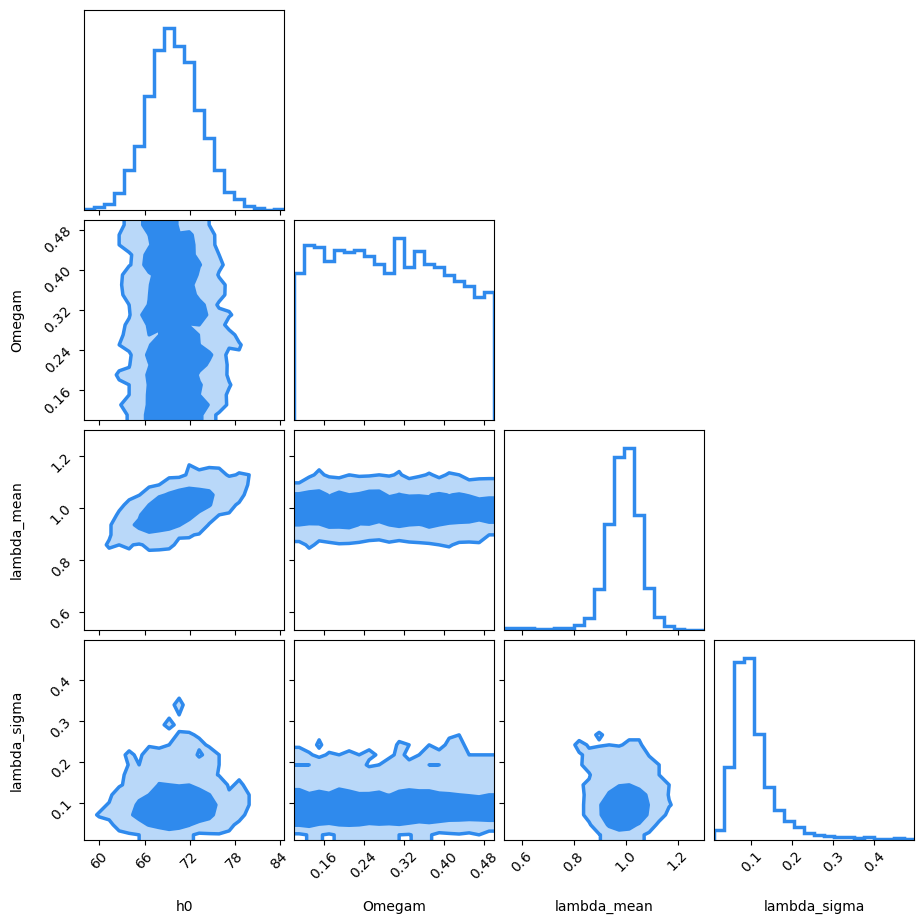

Saved: /mnt/d/lensing/LensedUniverse/test/test_quasar8_fiducial_no_extra_clean.nc
Saved: /mnt/d/lensing/LensedUniverse/test/test_quasar8_fiducial_no_extra_clean_trace.pdf
Saved: /mnt/d/lensing/LensedUniverse/test/test_quasar8_fiducial_no_extra_clean_corner.pdf


sample: 100%|██████████| 1500/1500 [00:28<00:00, 52.25it/s] 


[fiducial_plus8 | clean] divergences: 8

[fiducial_plus8 | clean] arviz summary
                 mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
h0            70.0378  5.2582  60.3312  80.2632     0.2099   0.1425   
Omegam         0.2856  0.1142   0.1047   0.4749     0.0019   0.0013   
lambda_mean    0.9907  0.0949   0.8031   1.1539     0.0037   0.0041   
lambda_sigma   0.1068  0.0649   0.0071   0.2190     0.0026   0.0032   

               ess_bulk   ess_tail   r_hat  
h0             637.9580   634.8042  1.0071  
Omegam        3438.6829  2109.1099  1.0012  
lambda_mean    721.0568   679.0270  1.0053  
lambda_sigma   562.8788   566.5012  1.0067  


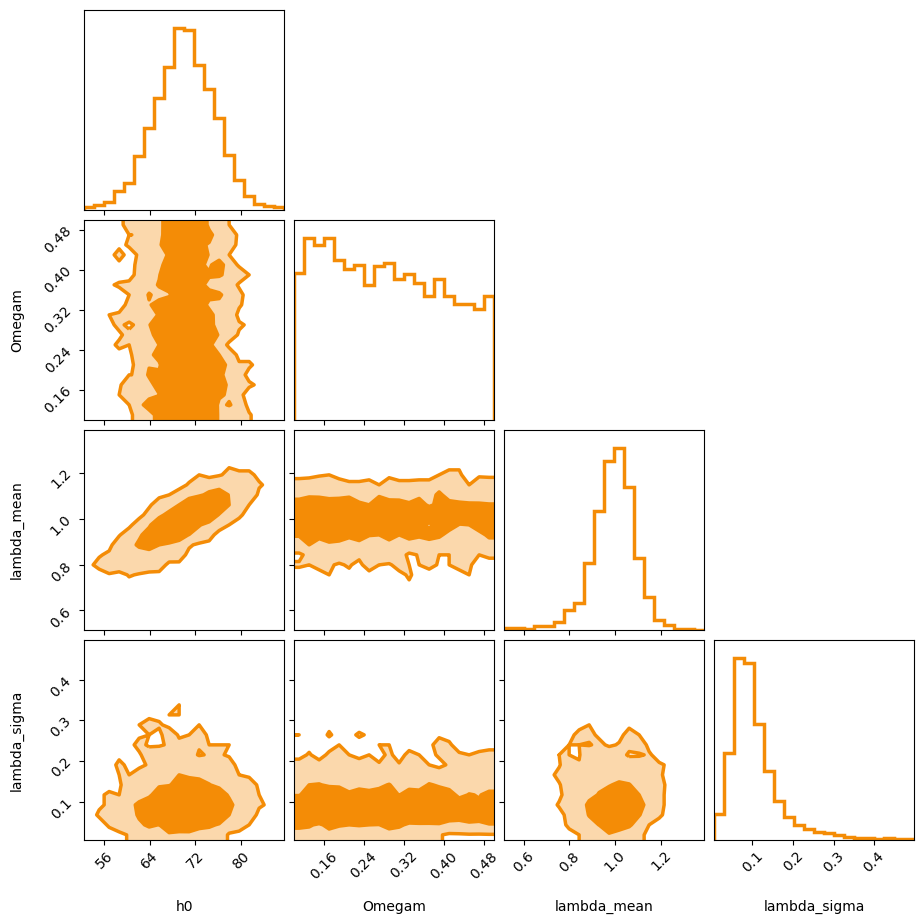

Saved: /mnt/d/lensing/LensedUniverse/test/test_quasar8_fiducial_plus8_clean.nc
Saved: /mnt/d/lensing/LensedUniverse/test/test_quasar8_fiducial_plus8_clean_trace.pdf
Saved: /mnt/d/lensing/LensedUniverse/test/test_quasar8_fiducial_plus8_clean_corner.pdf


sample: 100%|██████████| 1500/1500 [00:21<00:00, 70.99it/s] 


[population_only_no_mst_measure | clean] divergences: 0

[population_only_no_mst_measure | clean] arviz summary
           mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
h0      70.3364  3.1293  64.5004  76.3680     0.0686   0.0451  2084.0729   
Omegam   0.2928  0.1146   0.1004   0.4725     0.0013   0.0013  7116.3022   

         ess_tail   r_hat  
h0      2510.4477  1.0009  
Omegam  2715.8024  1.0012  


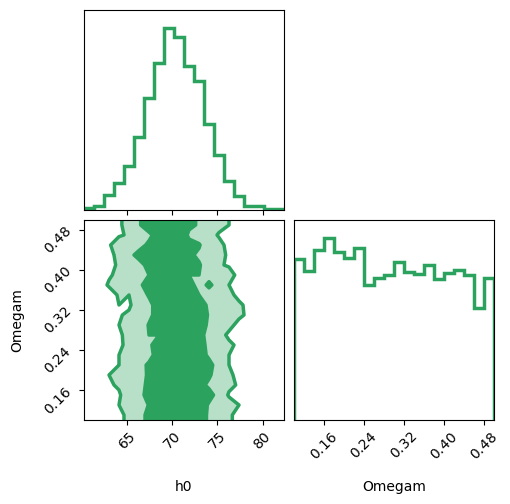

Saved: /mnt/d/lensing/LensedUniverse/test/test_quasar8_population_only_no_mst_measure_clean.nc
Saved: /mnt/d/lensing/LensedUniverse/test/test_quasar8_population_only_no_mst_measure_clean_trace.pdf
Saved: /mnt/d/lensing/LensedUniverse/test/test_quasar8_population_only_no_mst_measure_clean_corner.pdf


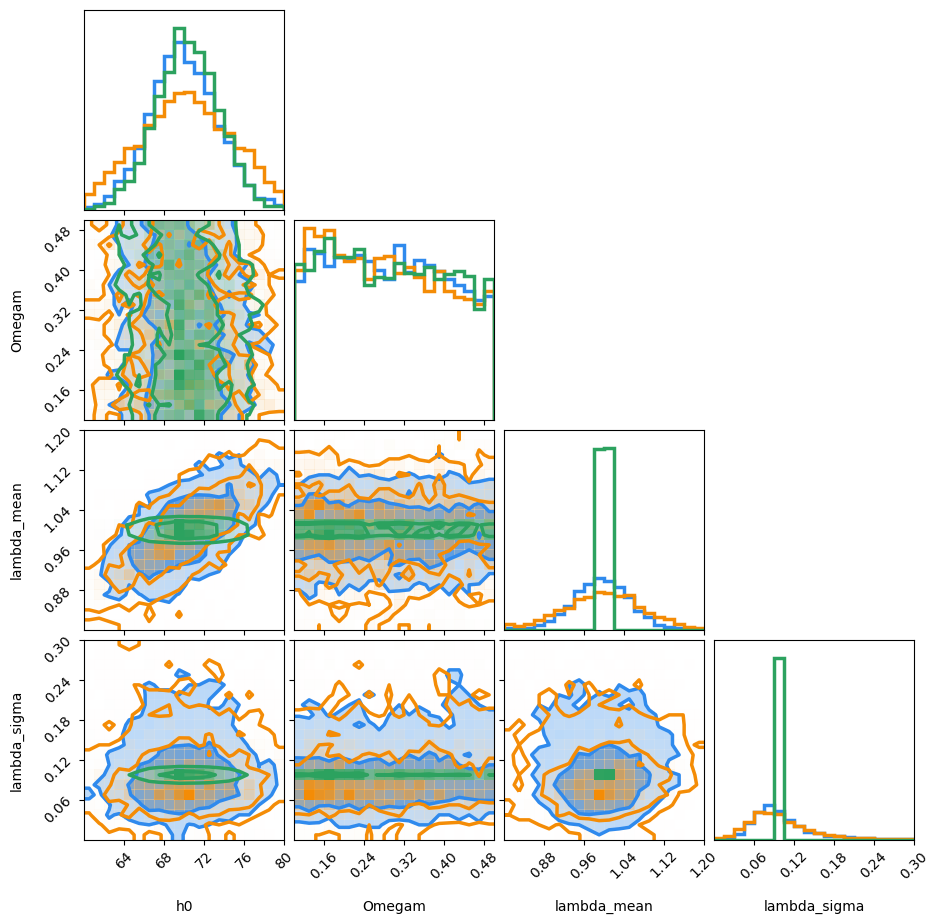

Saved: /mnt/d/lensing/LensedUniverse/test/test_quasar8_overlay_full_clean.pdf


sample: 100%|██████████| 1500/1500 [00:24<00:00, 62.08it/s] 


[fiducial_no_extra | noisy] divergences: 0

[fiducial_no_extra | noisy] arviz summary
                 mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
h0            70.5645  3.3296  64.3410  76.8759     0.0805   0.0520   
Omegam         0.2891  0.1144   0.1035   0.4746     0.0015   0.0014   
lambda_mean    1.0221  0.0749   0.8948   1.1665     0.0022   0.0034   
lambda_sigma   0.1301  0.0691   0.0358   0.2662     0.0025   0.0037   

               ess_bulk   ess_tail   r_hat  
h0            1707.4096  2120.6915  1.0019  
Omegam        4706.9554  2246.4366  1.0009  
lambda_mean   1372.3787   965.5964  1.0015  
lambda_sigma  1204.0170   789.2563  1.0007  


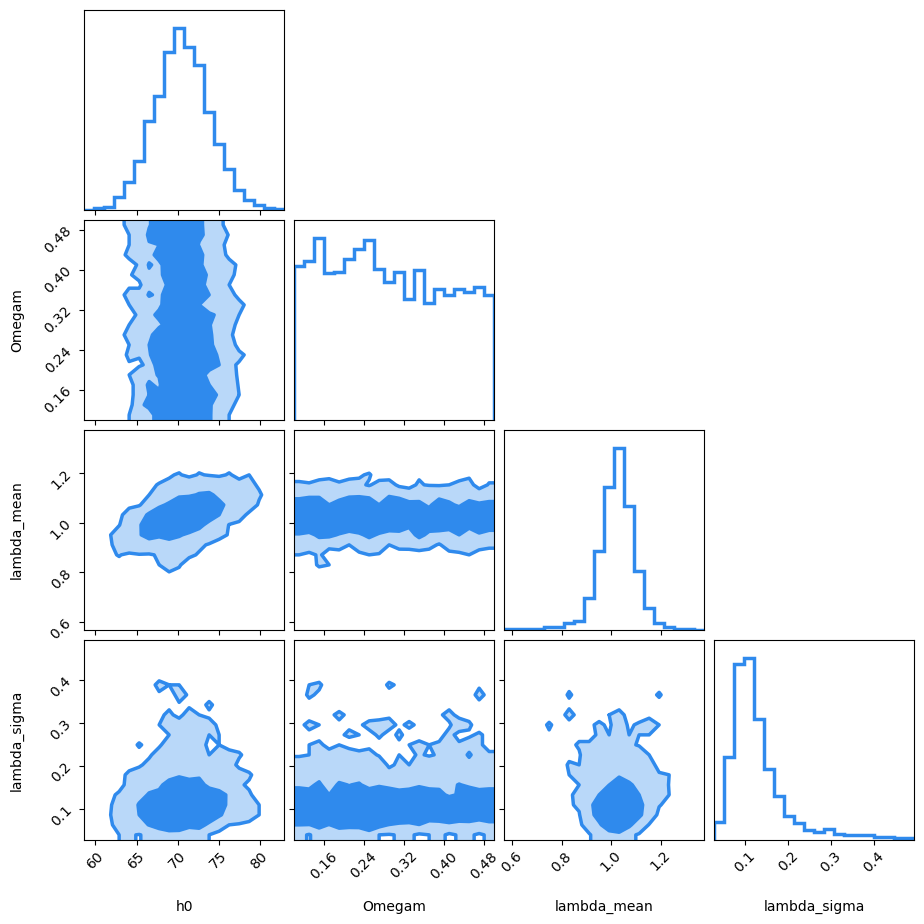

Saved: /mnt/d/lensing/LensedUniverse/test/test_quasar8_fiducial_no_extra_noisy.nc
Saved: /mnt/d/lensing/LensedUniverse/test/test_quasar8_fiducial_no_extra_noisy_trace.pdf
Saved: /mnt/d/lensing/LensedUniverse/test/test_quasar8_fiducial_no_extra_noisy_corner.pdf


sample: 100%|██████████| 1500/1500 [00:27<00:00, 55.45it/s] 


[fiducial_plus8 | noisy] divergences: 0

[fiducial_plus8 | noisy] arviz summary
                 mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
h0            66.1472  5.1783  56.0084  75.4113     0.1775   0.1028   
Omegam         0.2877  0.1116   0.1003   0.4679     0.0015   0.0013   
lambda_mean    0.9478  0.1105   0.7316   1.1532     0.0037   0.0036   
lambda_sigma   0.1437  0.0834   0.0426   0.3199     0.0037   0.0044   

               ess_bulk   ess_tail   r_hat  
h0             849.6728  1150.2124  1.0143  
Omegam        4814.3031  2695.3280  1.0010  
lambda_mean    951.9249  1037.1609  1.0118  
lambda_sigma   711.2198   601.8117  1.0191  


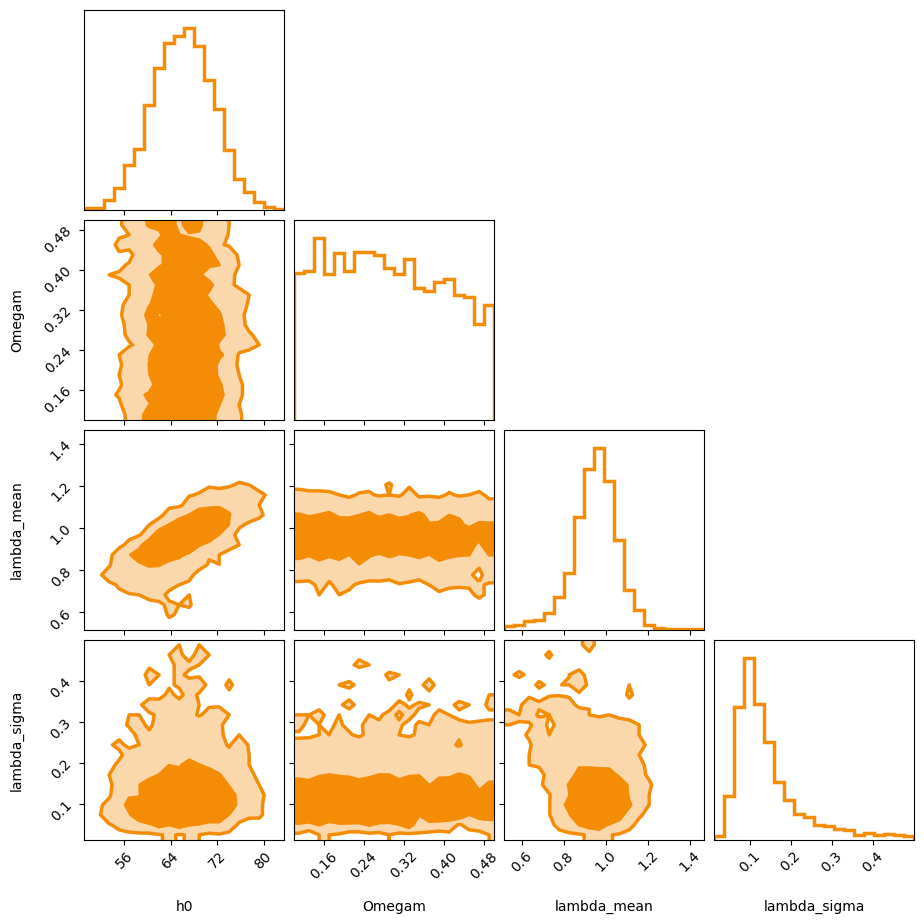

Saved: /mnt/d/lensing/LensedUniverse/test/test_quasar8_fiducial_plus8_noisy.nc
Saved: /mnt/d/lensing/LensedUniverse/test/test_quasar8_fiducial_plus8_noisy_trace.pdf
Saved: /mnt/d/lensing/LensedUniverse/test/test_quasar8_fiducial_plus8_noisy_corner.pdf


sample: 100%|██████████| 1500/1500 [00:22<00:00, 67.52it/s] 


[population_only_no_mst_measure | noisy] divergences: 0

[population_only_no_mst_measure | noisy] arviz summary
           mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
h0      68.7258  3.1262  63.0329  74.5628     0.0709   0.0460  1950.5685   
Omegam   0.2868  0.1107   0.1006   0.4659     0.0014   0.0013  5694.7354   

         ess_tail   r_hat  
h0      2462.0979  1.0022  
Omegam  2493.5306  1.0018  


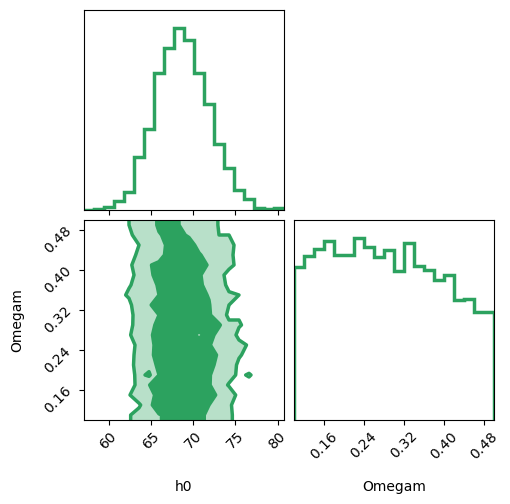

Saved: /mnt/d/lensing/LensedUniverse/test/test_quasar8_population_only_no_mst_measure_noisy.nc
Saved: /mnt/d/lensing/LensedUniverse/test/test_quasar8_population_only_no_mst_measure_noisy_trace.pdf
Saved: /mnt/d/lensing/LensedUniverse/test/test_quasar8_population_only_no_mst_measure_noisy_corner.pdf


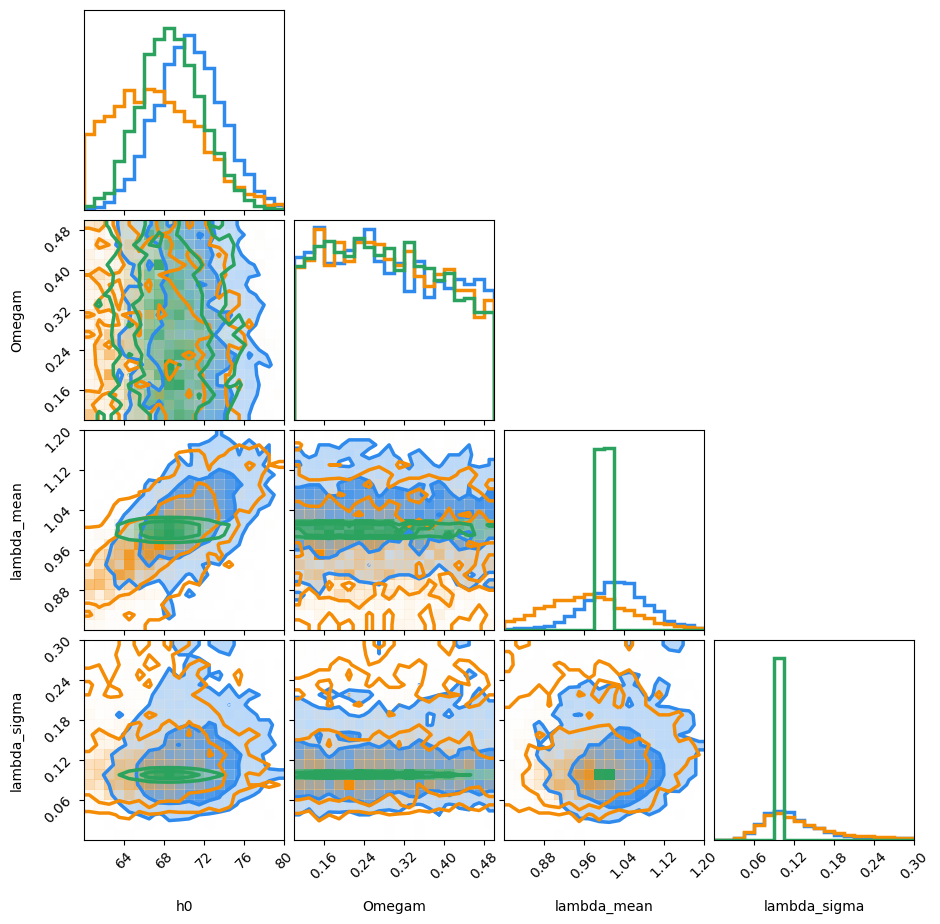

Saved: /mnt/d/lensing/LensedUniverse/test/test_quasar8_overlay_full_noisy.pdf


In [5]:
# ---------------------------
# Run three scenarios with clean and noisy data
# ---------------------------
RUN_MCMC = True
TARGET_ACCEPT = 0.99
NUM_WARMUP = 500
NUM_SAMPLES = 1000
NUM_CHAINS = 4


def run_mcmc(scenario_name, scenario, mode_name, mode_data, key):
    init_values = build_init_values(mode_data['phi_obs_scaled'], bool(scenario['infer_lambda_population']))
    nuts = NUTS(
        quasar_td_lcdm_model,
        target_accept_prob=TARGET_ACCEPT,
        init_strategy=init_to_value(values=init_values),
    )
    mcmc = MCMC(
        nuts,
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
        num_chains=NUM_CHAINS,
        chain_method='vectorized',
        progress_bar=True,
    )

    mcmc.run(
        key,
        z_lens=z_lens,
        z_src=z_src,
        t_obs=mode_data['t_obs'],
        t_err=t_err,
        phi_obs_scaled=mode_data['phi_obs_scaled'],
        phi_err_scaled=phi_err_scaled,
        phi_scale=phi_scale,
        lambda_obs=scenario[f'lambda_obs_{mode_name}'],
        lambda_err=scenario['lambda_err'],
        kext_obs=scenario[f'kext_obs_{mode_name}'],
        kext_err=scenario['kext_err'],
        use_mst_measurement=bool(scenario['use_mst_measurement']),
        infer_lambda_population=bool(scenario['infer_lambda_population']),
    )

    extra = mcmc.get_extra_fields(group_by_chain=True)
    n_div = int(np.asarray(extra['diverging']).sum())
    print(f'[{scenario_name} | {mode_name}] divergences:', n_div)

    posterior = mcmc.get_samples(group_by_chain=True)
    inf_data = az.from_dict(posterior=posterior)
    return inf_data


def make_single_corner(idata, var_names, outfile, color):
    fig = corner(
        idata,
        var_names=var_names,
        labels=var_names,
        color=color,
        show_titles=False,
        levels=[0.68, 0.95],
        fill_contours=True,
        plot_datapoints=False,
        smooth=0.2,
        use_math_text=True,
        contour_kwargs={'linewidths': 2.5},
        hist_kwargs={'density': True, 'linewidth': 2.5},
    )
    fig.savefig(outfile, bbox_inches='tight')
    plt.show()
    plt.close(fig)


if RUN_MCMC:
    order = ['fiducial_no_extra', 'fiducial_plus8', 'population_only_no_mst_measure']
    mode_order = ['clean', 'noisy']

    keys = random.split(random.PRNGKey(SEED), len(order) * len(mode_order))
    key_idx = 0

    inference_results = {mode: {} for mode in mode_order}

    for mode in mode_order:
        for i, name in enumerate(order):
            scenario = scenario_data[name]
            mode_data = data_modes[mode]
            inf_data = run_mcmc(name, scenario, mode, mode_data, keys[key_idx])
            key_idx += 1
            inference_results[mode][name] = inf_data

            nc_path = RESULT_DIR / f'test_quasar8_{name}_{mode}.nc'
            az.to_netcdf(inf_data, nc_path)

            trace_vars = ['h0', 'Omegam']
            corner_vars = ['h0', 'Omegam']
            if scenario['infer_lambda_population']:
                trace_vars += ['lambda_mean', 'lambda_sigma']
                corner_vars = ['h0', 'Omegam', 'lambda_mean', 'lambda_sigma']

            axes = az.plot_trace(inf_data, var_names=trace_vars, compact=True)
            fig_trace = axes.ravel()[0].figure
            trace_path = RESULT_DIR / f'test_quasar8_{name}_{mode}_trace.pdf'
            fig_trace.savefig(trace_path, bbox_inches='tight')
            plt.close(fig_trace)

            print(f"\n[{name} | {mode}] arviz summary")
            print(az.summary(inf_data, var_names=trace_vars, round_to=4))

            corner_path = RESULT_DIR / f'test_quasar8_{name}_{mode}_corner.pdf'
            make_single_corner(
                inf_data,
                corner_vars,
                corner_path,
                '#2f8aed' if i == 0 else ('#f48c06' if i == 1 else '#2ca25f'),
            )

            print('Saved:', nc_path)
            print('Saved:', trace_path)
            print('Saved:', corner_path)

        # Final corner overlay: three scenarios together with full parameter set
        # Third scenario has no lambda population posterior, so add synthetic plotting chains.
        overlay_vars = ['h0', 'Omegam', 'lambda_mean', 'lambda_sigma']
        overlay_ranges = [(60.0, 80.0), (0.1, 0.5), (0.8, 1.2), (0.0, 0.3)]

        def build_overlay_idata(idata, seed_offset):
            post = idata.posterior
            n_chain = int(post.sizes['chain'])
            n_draw = int(post.sizes['draw'])
            overlay_post = {
                'h0': np.asarray(post['h0'].values),
                'Omegam': np.asarray(post['Omegam'].values),
            }
            if ('lambda_mean' in post.data_vars) and ('lambda_sigma' in post.data_vars):
                overlay_post['lambda_mean'] = np.asarray(post['lambda_mean'].values)
                overlay_post['lambda_sigma'] = np.asarray(post['lambda_sigma'].values)
            else:
                # Third chain synthetic values for plotting stability (inside plotting range).
                rng_overlay = np.random.default_rng(SEED + seed_offset)
                overlay_post['lambda_mean'] = np.clip(
                    1.0 + rng_overlay.normal(0.0, 1e-3, size=(n_chain, n_draw)),
                    0.8,
                    1.2,
                )
                overlay_post['lambda_sigma'] = np.clip(
                    0.1 + rng_overlay.normal(0.0, 1e-3, size=(n_chain, n_draw)),
                    1e-6,
                    0.3,
                )
            return az.from_dict(posterior=overlay_post)

        idata_overlay_0 = build_overlay_idata(inference_results[mode][order[0]], 101)
        idata_overlay_1 = build_overlay_idata(inference_results[mode][order[1]], 202)
        idata_overlay_2 = build_overlay_idata(inference_results[mode][order[2]], 303)

        fig = corner(
            idata_overlay_0,
            var_names=overlay_vars,
            labels=overlay_vars,
            range=overlay_ranges,
            color='#2f8aed',
            show_titles=False,
            levels=[0.68, 0.95],
            fill_contours=True,
            plot_datapoints=False,
            smooth=0.2,
            use_math_text=True,
            contour_kwargs={'linewidths': 2.5},
            hist_kwargs={'density': True, 'linewidth': 2.5},
        )
        corner(
            idata_overlay_1,
            fig=fig,
            var_names=overlay_vars,
            labels=overlay_vars,
            range=overlay_ranges,
            color='#f48c06',
            show_titles=False,
            levels=[0.68, 0.95],
            fill_contours=False,
            no_fill_contours=True,
            plot_datapoints=False,
            smooth=0.2,
            use_math_text=True,
            contour_kwargs={'linewidths': 2.5},
            hist_kwargs={'density': True, 'linewidth': 2.5, 'histtype': 'step'},
        )
        corner(
            idata_overlay_2,
            fig=fig,
            var_names=overlay_vars,
            labels=overlay_vars,
            range=overlay_ranges,
            color='#2ca25f',
            show_titles=False,
            levels=[0.68, 0.95],
            fill_contours=False,
            no_fill_contours=True,
            plot_datapoints=False,
            smooth=0.2,
            use_math_text=True,
            contour_kwargs={'linewidths': 2.5},
            hist_kwargs={'density': True, 'linewidth': 2.5, 'histtype': 'step'},
        )
        overlay_path = RESULT_DIR / f'test_quasar8_overlay_full_{mode}.pdf'
        fig.savefig(overlay_path, bbox_inches='tight')
        plt.show()
        plt.close(fig)
        print('Saved:', overlay_path)





